# QR Heston SPX and VIX smiles from simulation

We use the QRH scheme from `QRH SSR.pdf` to generate SPX and VIX smiles.


In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [ ]:
import numpy as np
import pandas as pd
from utils import var_swap_robust, plot_ivols_mc
from fwd_var_curve import xi_curve_smooth
import matplotlib.pyplot as plt
from scipy import integrate
from qrheston import QuadraticRoughHeston

plt.style.use("notebook")

# Gamma kernel

The gamma kernel is given by $$ \kappa(\tau)= \frac{\nu}{\Gamma(\alpha)}\, \tau^{\alpha-1}\,e^{-\lambda \tau}, $$

with $\alpha = H + \tfrac12$.


In [3]:
params0 = {"al": 0.568, "lam": 9.68, "nu": 0.572, "c": 8.1e-3}

# Kernel convergence condition


We check the necessary condition $$ \int_0^\infty \kappa(s)^2 \, ds = \frac{\nu^2}{\Gamma(\alpha)^2} \frac{\Gamma(2 H)}{(2\lambda)^{2H}} < 1 $$


In [4]:
from scipy.special import gamma


def converge_test(params, opt="closed-form"):
    al = params["al"]
    H = al - 1 / 2
    lam = params["lam"]
    nu = params["nu"]

    if opt == "closed-form":
        integral = (nu / gamma(al)) ** 2 * gamma(2 * H) / (2 * lam) ** (2 * H)
    elif opt == "quad":

        def kernel(x):
            return (nu / gamma(al)) * x ** (al - 1) * np.exp(-lam * x)

        integral = integrate.quad(lambda x: kernel(x) ** 2, 0, np.inf)[0]
    else:
        raise ValueError("Check value for opt.")

    assert integral < 1
    return integral


print(converge_test(params0, opt="closed-form"))
print(converge_test(params0, opt="quad"))

0.6137021325532132
0.6137021324510988


# Initial forward variance curve $\xi_t(u)$


In [5]:
# Load market data
df_spx = pd.read_csv("spx_implied_vol_20230215.csv", index_col=0)
df_vix = pd.read_csv("vix_implied_vol_20230215.csv", index_col=0)
df_spx["Texp_days"] = (365.25 * df_spx["Texp"]).round().astype(int)
df_vix["Texp_days"] = (365.25 * df_vix["Texp"]).round().astype(int)

In [6]:
res_vs = var_swap_robust(ivol_data=df_spx)
w_in = res_vs["vs_mid"] * res_vs["expiries"]
xi_smooth = xi_curve_smooth(res_vs["expiries"], w_in, eps=0.03)["xi_curve"]

/Users/florianbourgey/projects/gatheral/QuadraticRoughHeston/Python/utils.py:156: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  wbar_flat = quad(PchipInterpolator(np.sort(y_in), sig_in_y**2), y_min, y_max)[0]


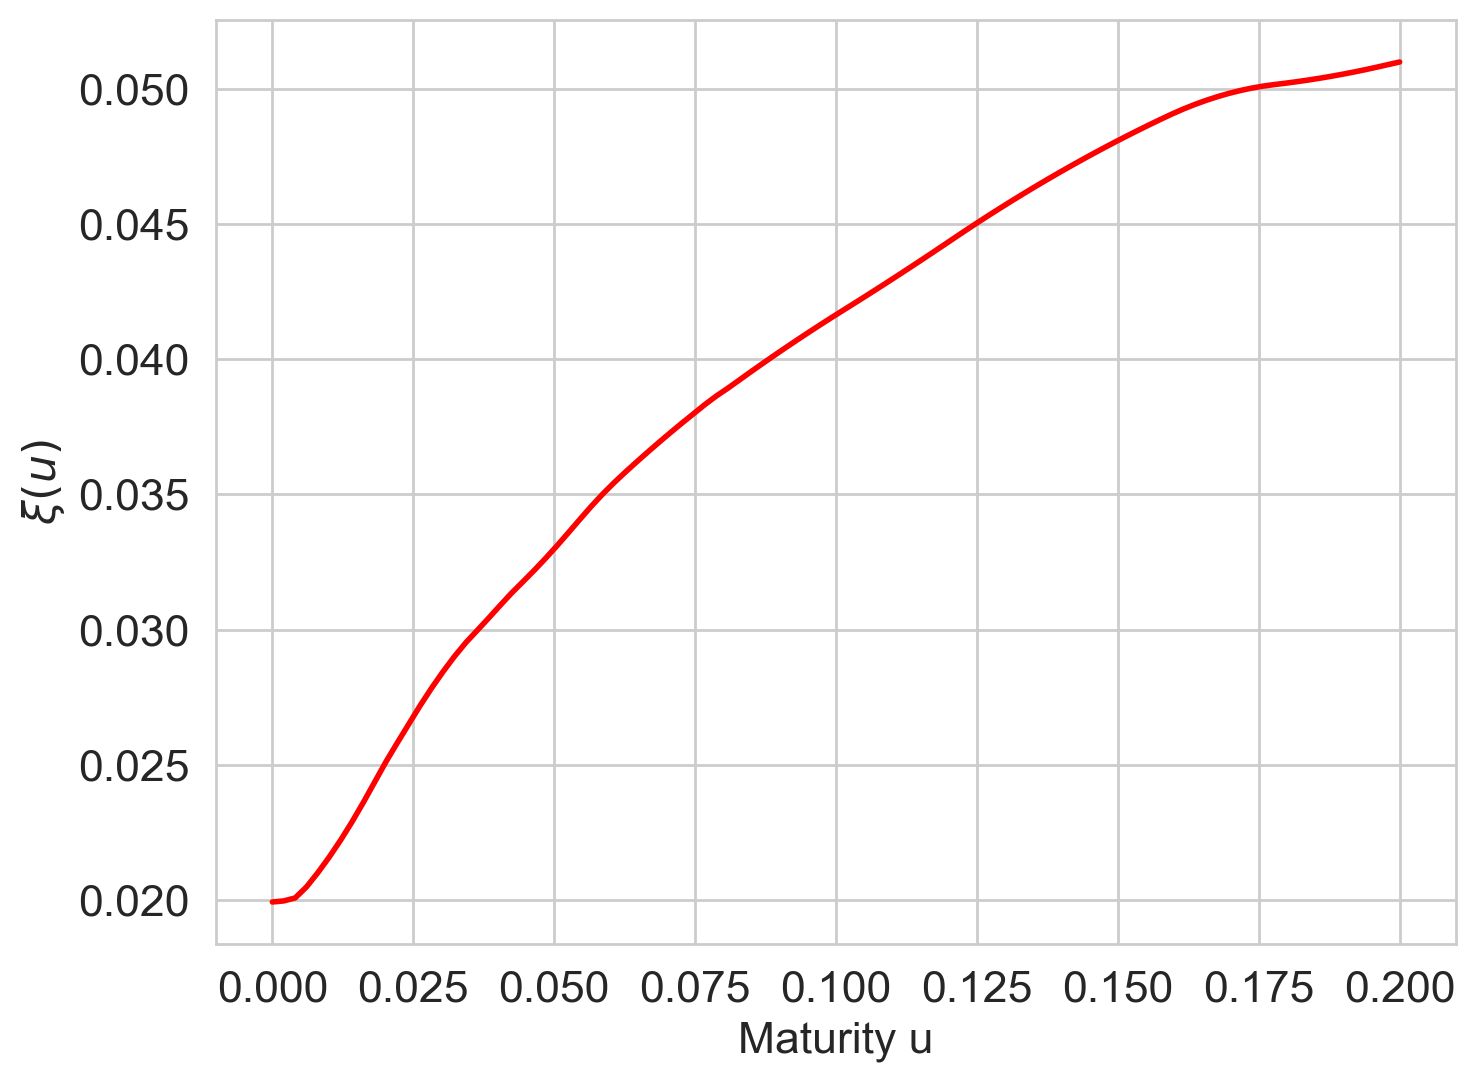

In [7]:
u = np.linspace(0, 0.2, 100)
fig, ax = plt.subplots()
ax.plot(u, xi_smooth(u), color="red", linewidth=2)
ax.set_xlabel("Maturity u")
ax.set_ylabel(r"$\xi(u)$")
plt.show()

# $y_t(u)$ from $\xi_t(u)$

$$ y_t(u)^2= \xi_t(u) - c - \int_t^u\,\xi_t(s)\,\kappa (u-s)^2\,ds. $$

Integration is performed using Gauss-Jacobi quadrature.


In [8]:
qrh = QuadraticRoughHeston(**params0, xi0=xi_smooth)

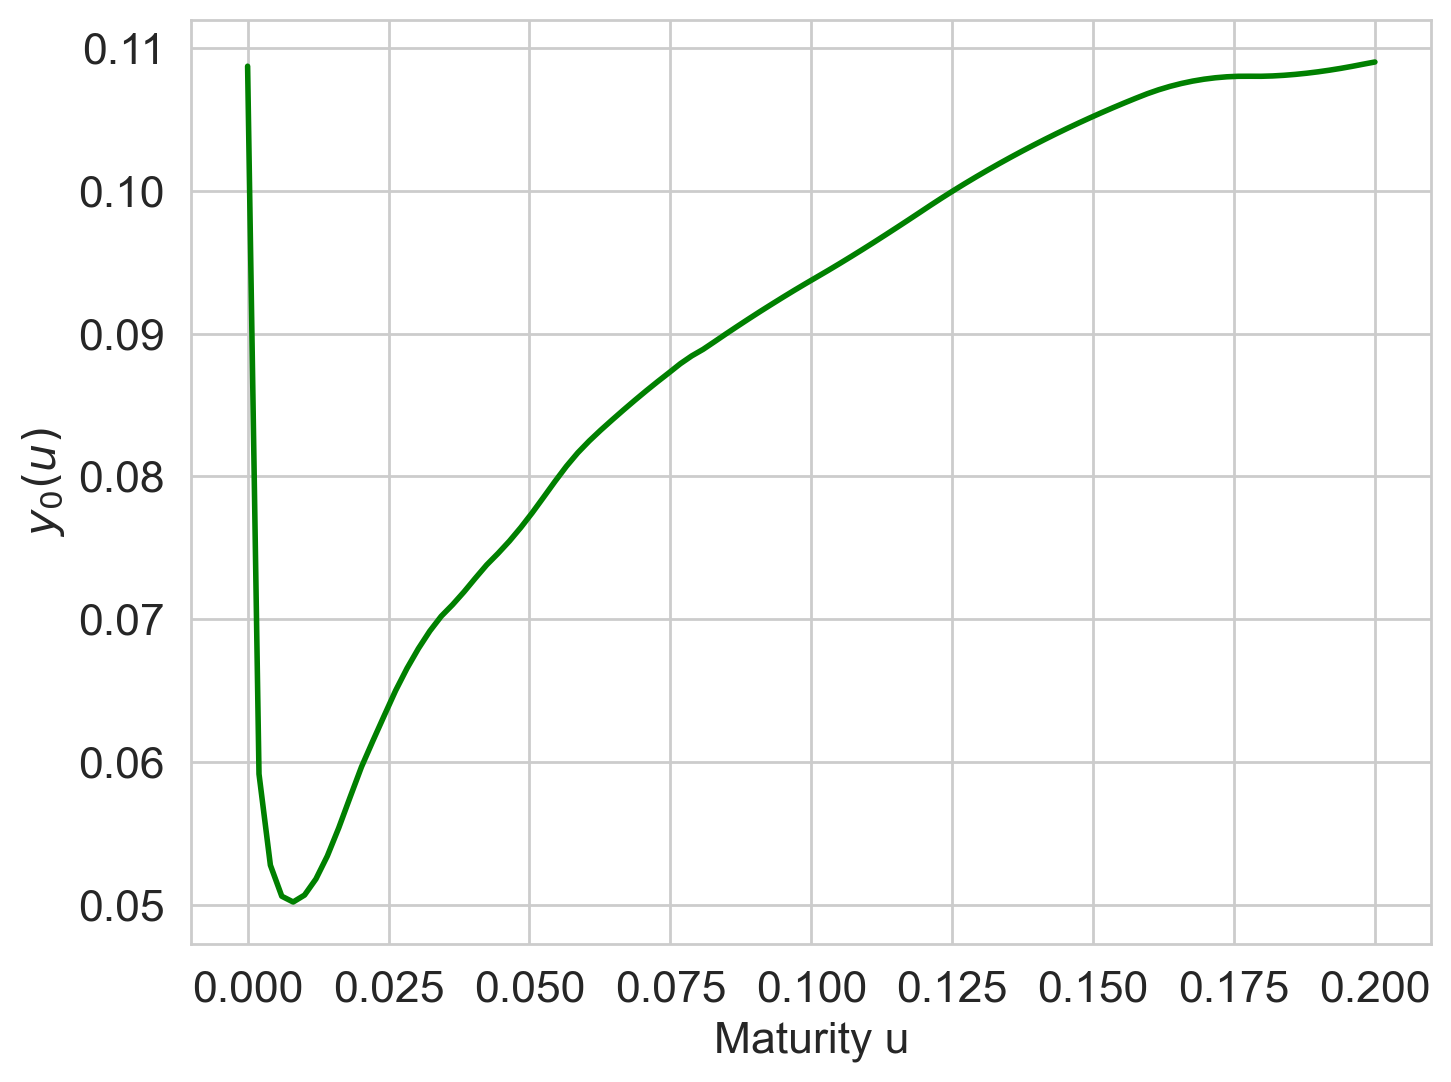

In [9]:
u = np.linspace(0, 0.2, 100)
fig, ax = plt.subplots()
ax.plot(u, qrh.y0(u), color="g", linewidth=2)
ax.set_xlabel("Maturity u")
ax.set_ylabel(r"$y_0(u)$")
plt.show()

# Choose expiries


In this particular case, we choose identical SPX and VIX expiries.

Here, expiries are $7,14,20,28$ days.


In [10]:
spx_expiries_days = [7, 14, 20, 28]
vix_expiries_days = [7, 14, 20, 28]
spx_expiries = np.array(spx_expiries_days) / 365.25
vix_expiries = np.array(vix_expiries_days) / 365.25

# Run simulations


In [11]:
paths = 2 * 10**5
steps = 300

In [ ]:
res = qrh.simulate(paths=paths, steps=steps, expiries=spx_expiries, output="all")

# SPX smiles


In [13]:
spx_mc_matrix = np.array([np.exp(res[exp]["X"]) for exp in spx_expiries])

In [ ]:
df_spx_sub = (
    df_spx[df_spx["Texp_days"].isin(spx_expiries_days)].dropna().reset_index(drop=True)
)

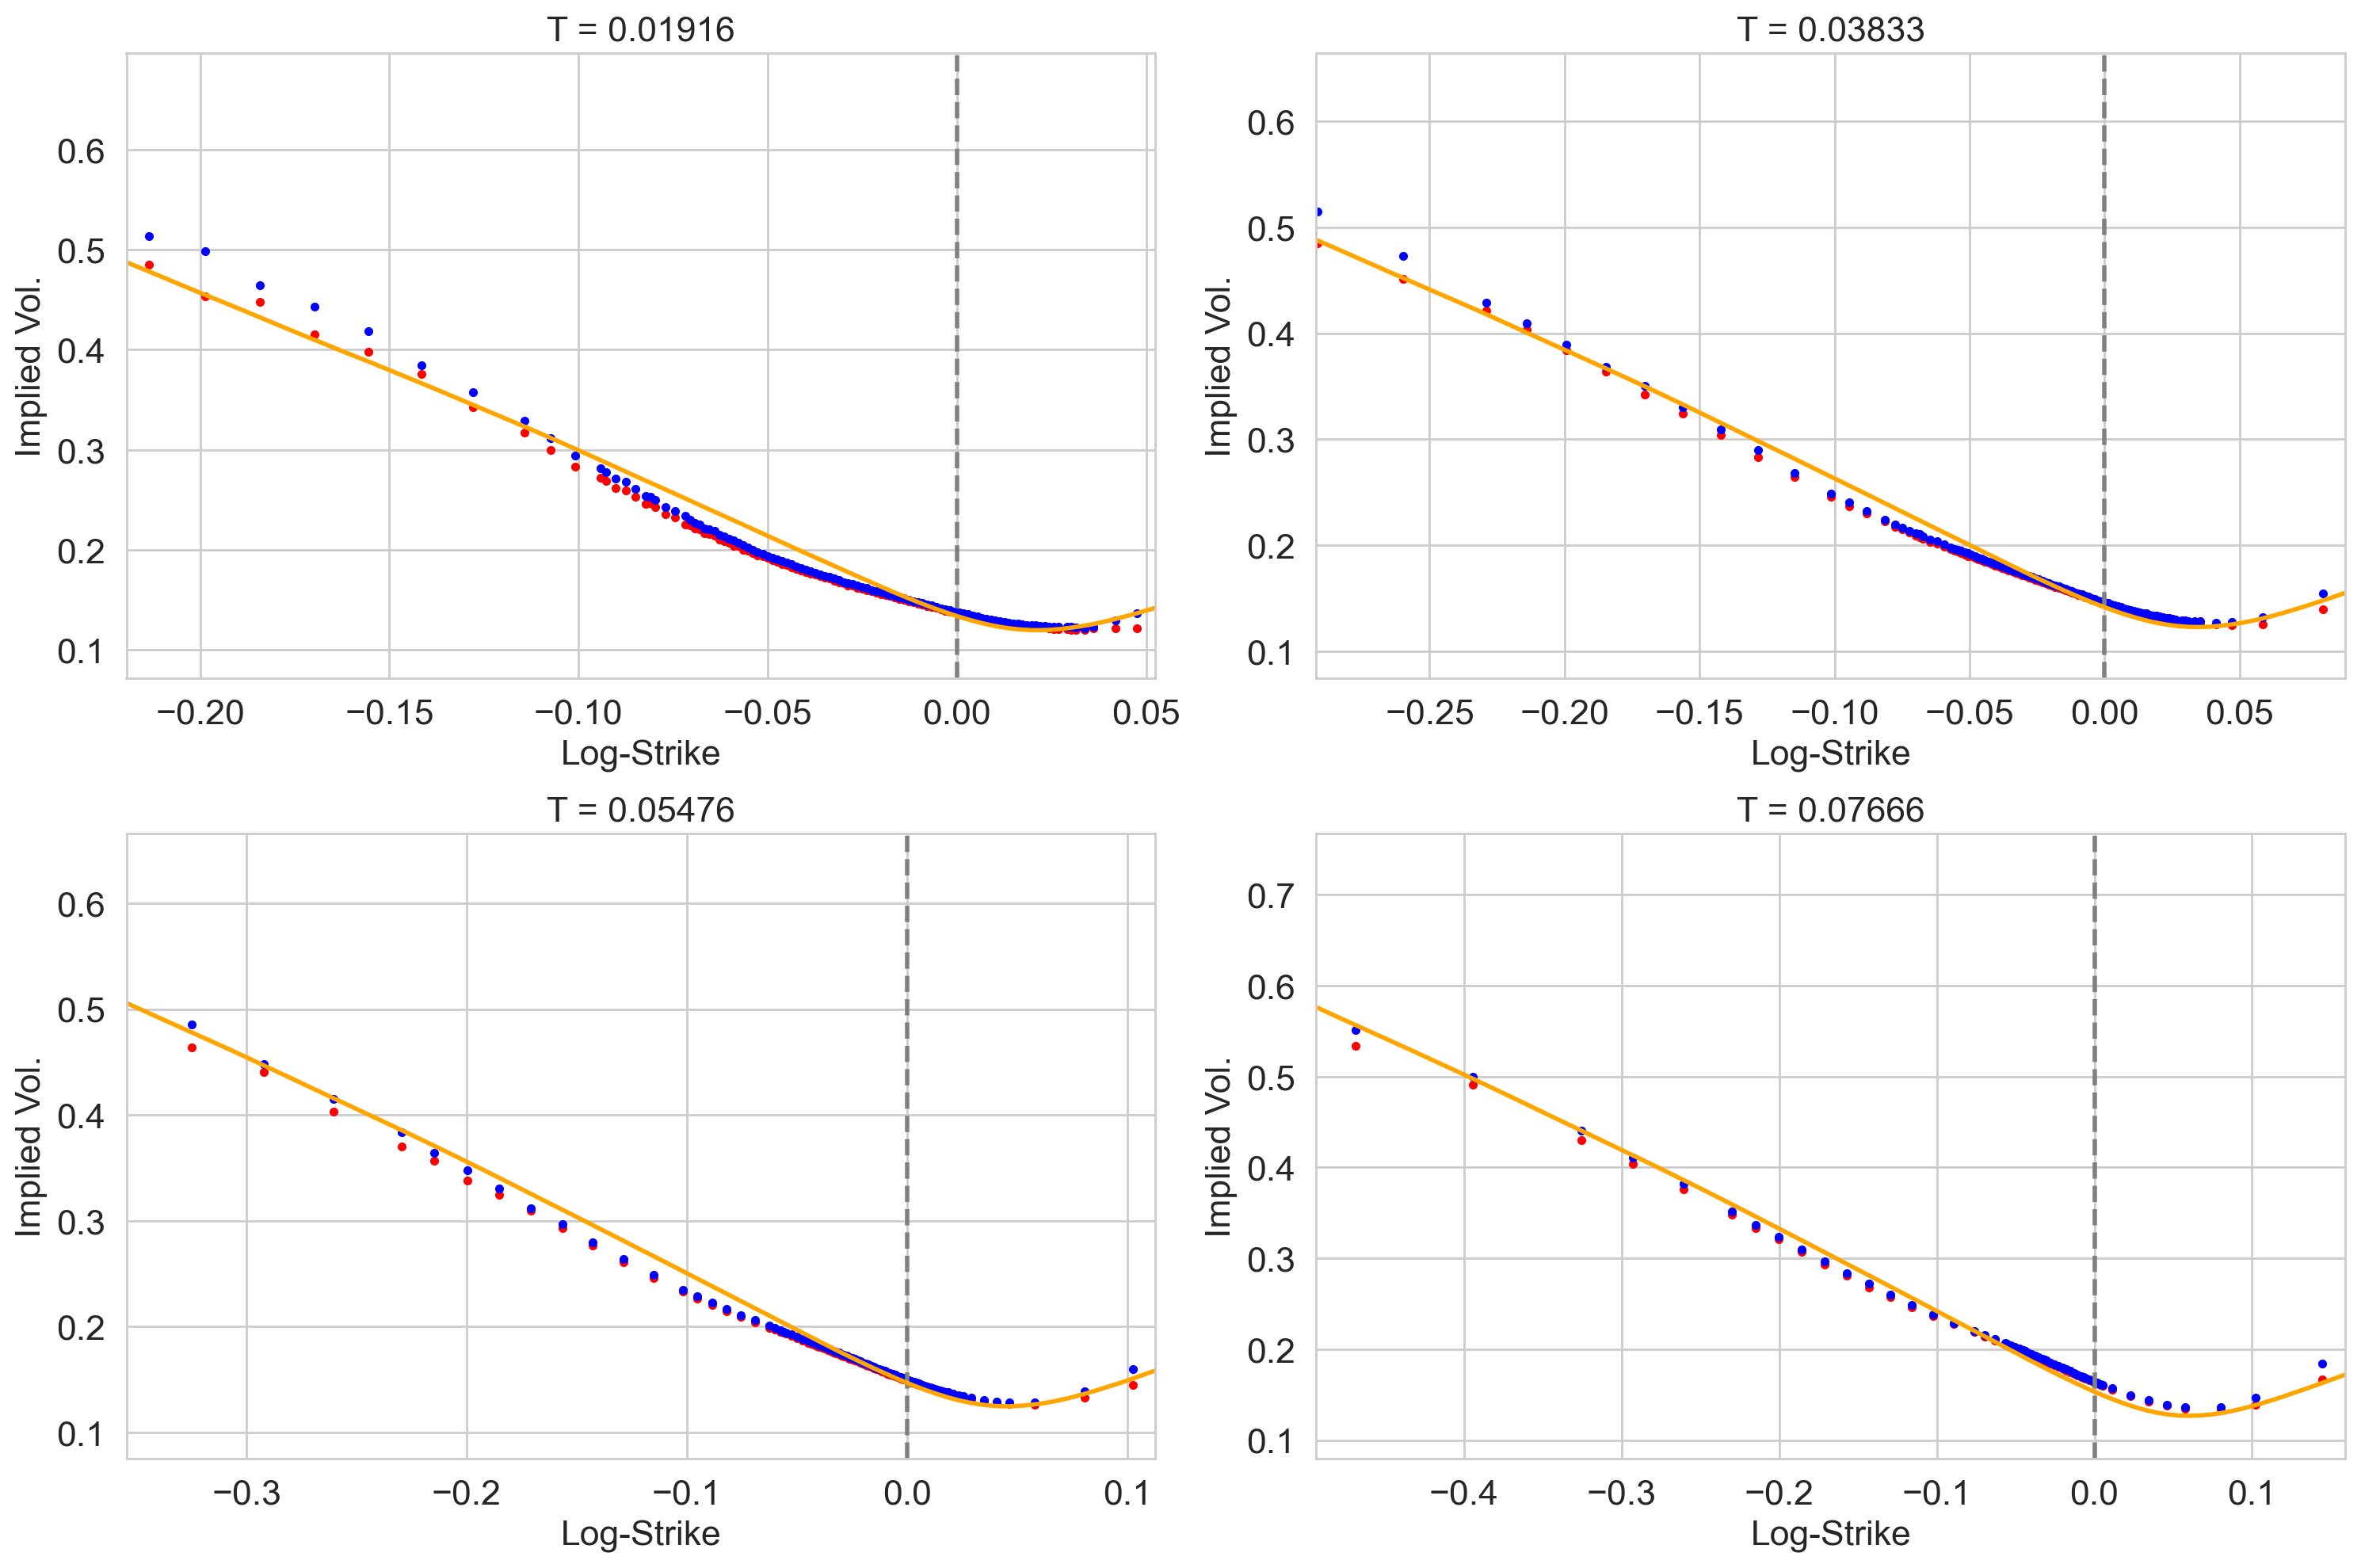

In [15]:
plot_spx = plot_ivols_mc(ivol_data=df_spx_sub, mc_matrix=spx_mc_matrix)

# VIX smiles


In [ ]:
vix_mc_matrix = np.array([res[exp]["vix"] for exp in vix_expiries])
df_vix_sub = (
    df_vix[df_vix["Texp_days"].isin(vix_expiries_days)].dropna().reset_index(drop=True)
)

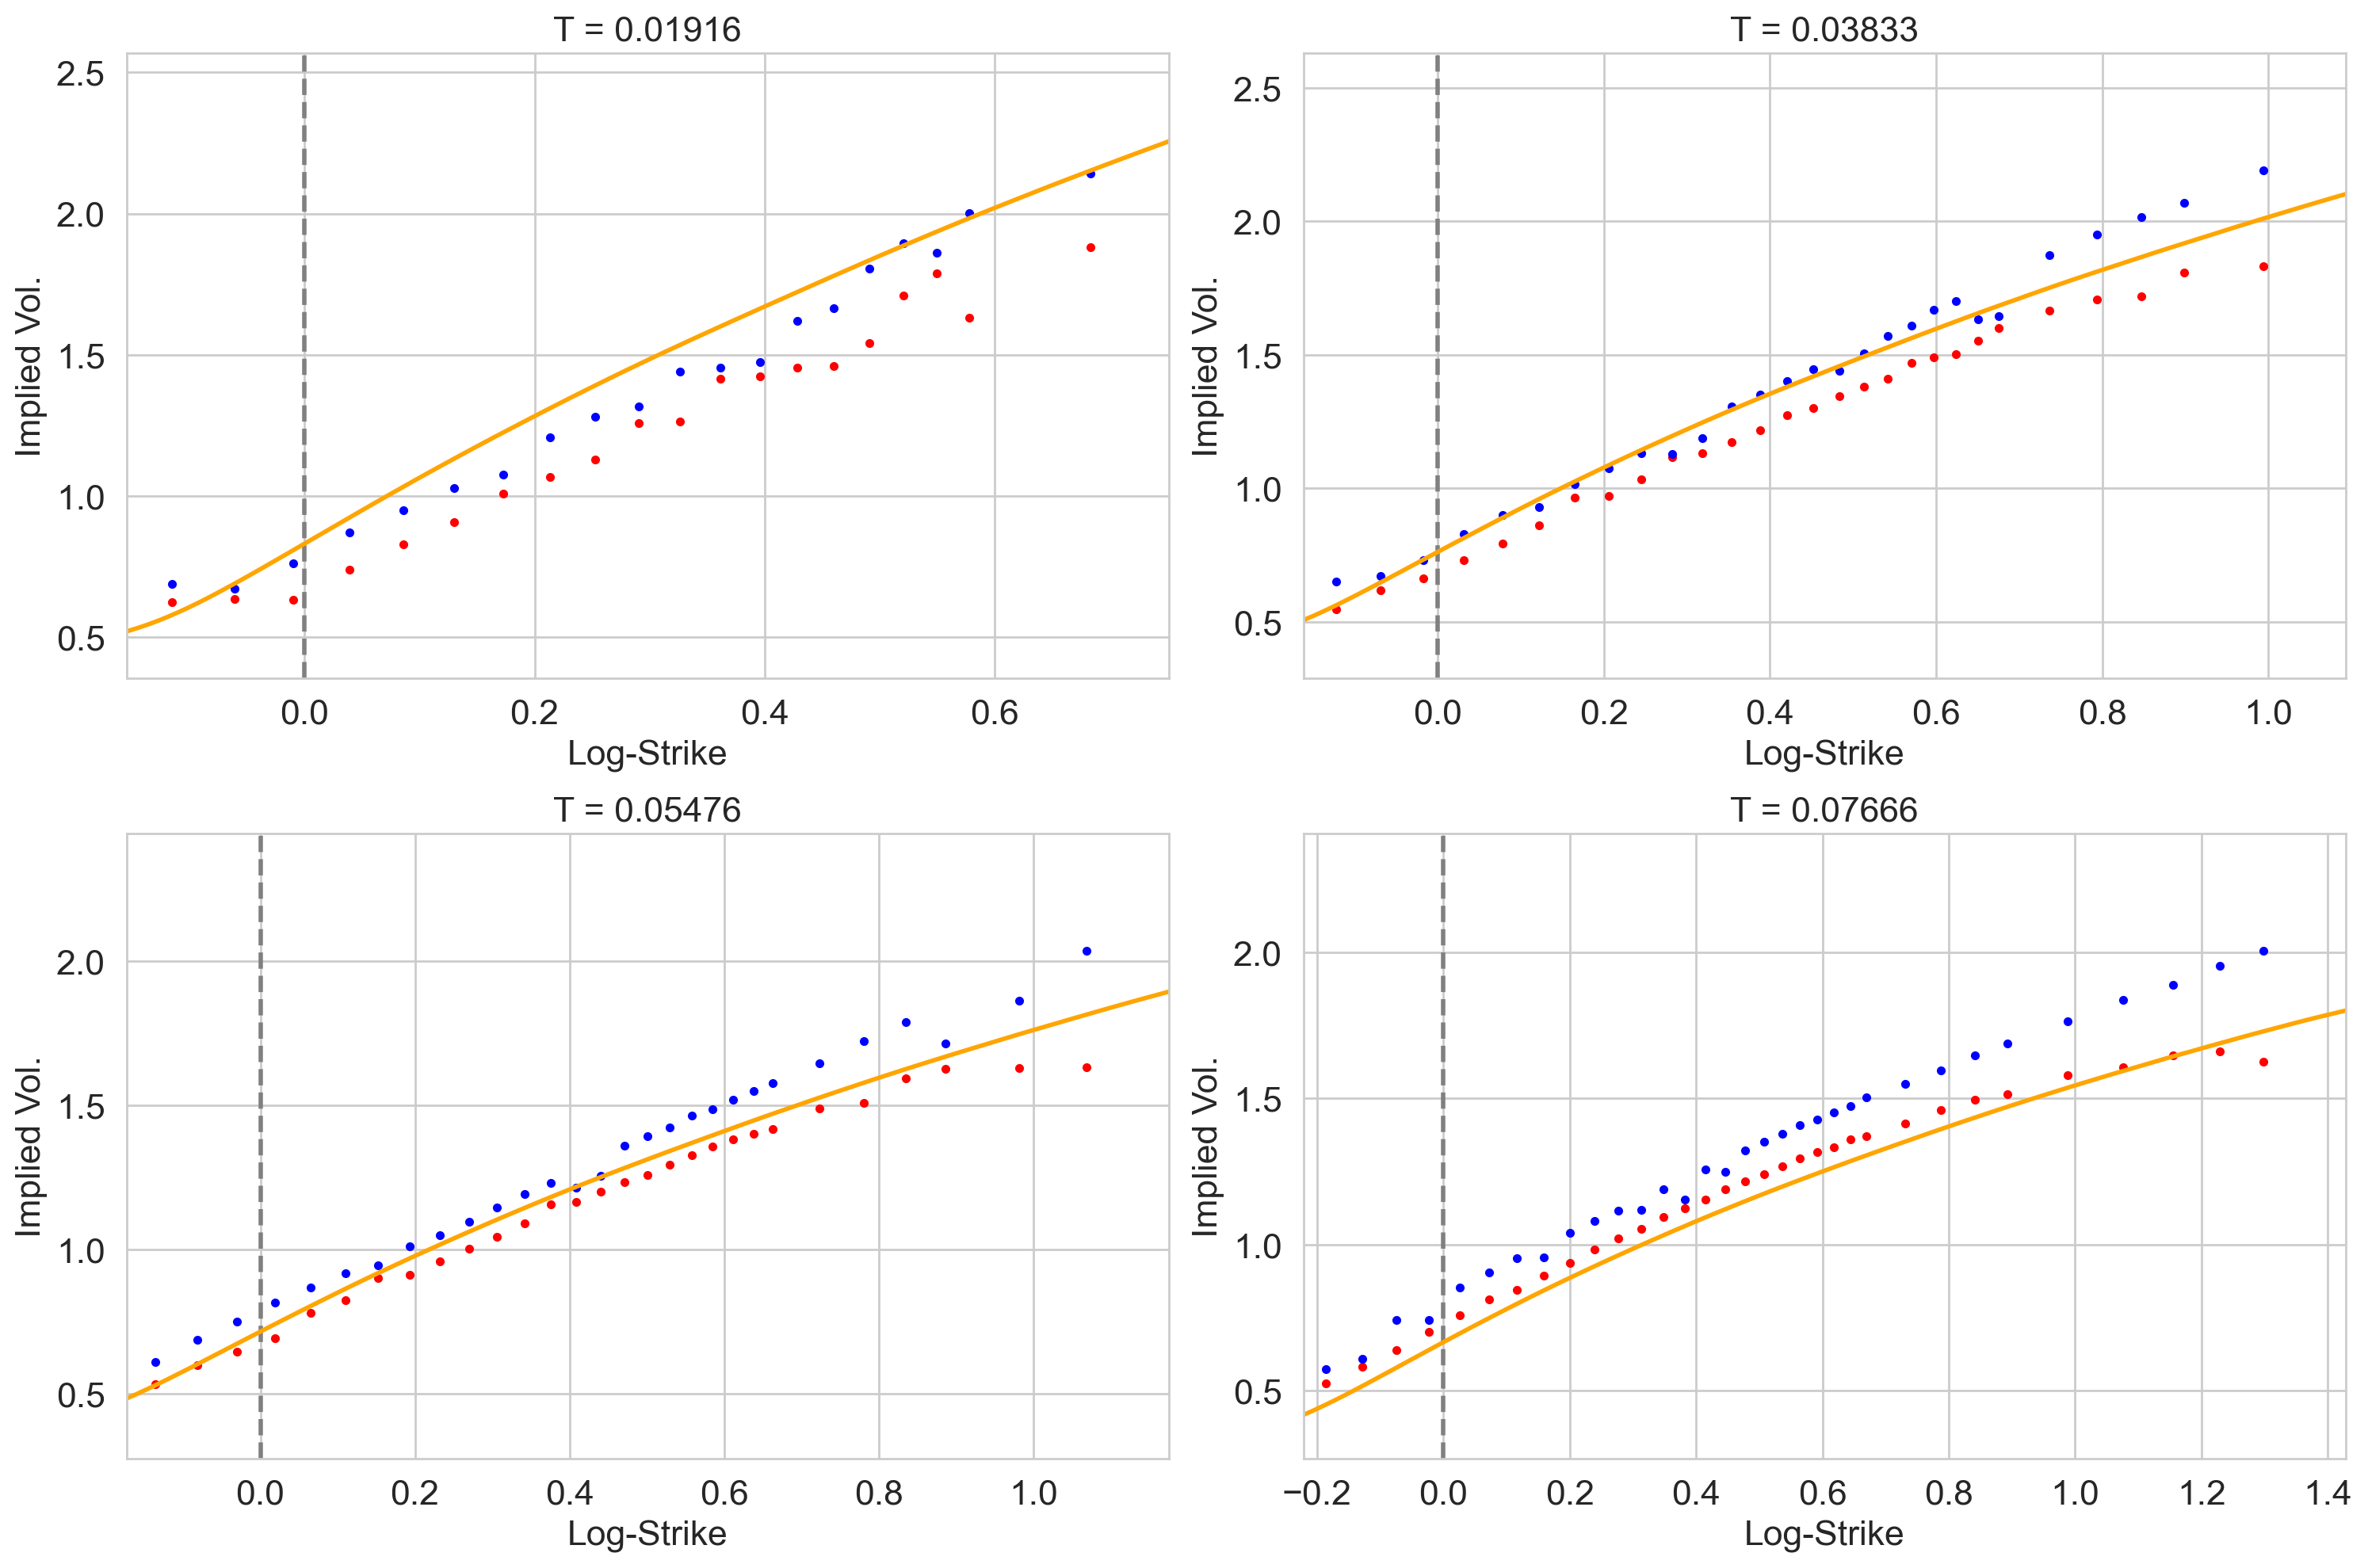

In [17]:
plot_vix = plot_ivols_mc(ivol_data=df_vix_sub, mc_matrix=vix_mc_matrix)